In [1]:
import sys
sys.path.append('../chromdyn')
from Topology import TopologyGenerator
from ChromatinDynamics import ChromatinDynamics
from Reporters import save_pdb

from HiCManager import HiCManager
hicman = HiCManager()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
#Initialize generator object
generator = TopologyGenerator()

#generate topology
generator.gen_top([100])

In [3]:
#Initialize simulation object
#output will be generated if not present
sim = ChromatinDynamics(generator.topology, name = 'test', platform_name = "OpenCL", output_dir = "output", console_stream = True)

2025-08-13 15:11:06,954 | INFO | ChromatinDynamics | ************************************************************
2025-08-13 15:11:06,955 | INFO | ChromatinDynamics |                      Chromatin Dynamics                     
2025-08-13 15:11:06,955 | INFO | ChromatinDynamics | ************************************************************
2025-08-13 15:11:06,956 | INFO | ChromatinDynamics | System initialized with 100 particles. Output directory: output
2025-08-13 15:11:06,956 | INFO | Platforms | Platform 'OpenCL' is available and selected.
2025-08-13 15:11:06,956 | INFO | ChromatinDynamics | force_field_manager initialized. Use this to add forces before running setup.


In [4]:
#Add forces
sim.force_field_manager.add_harmonic_bonds()
sim.force_field_manager.add_self_avoidance()
sim.force_field_manager.add_flat_bottom_harmonic()

2025-08-13 15:11:07,800 | INFO | Forcefield | Adding 99 harmonic bonds with r0=1.0, k=10.0, group=0
2025-08-13 15:11:07,801 | INFO | Forcefield | HarmonicBonds force successfully added to system.
2025-08-13 15:11:07,801 | INFO | Forcefield | --------------------------------------------------
2025-08-13 15:11:07,802 | INFO | Forcefield | Adding Self-avoidance force with parameters:
2025-08-13 15:11:07,802 | INFO | Forcefield | Ecut=4.0, k_rep=5.0, r_rep=1.0, cutoff=5.0, group=2
2025-08-13 15:11:07,803 | INFO | Forcefield | Added exclusions from bonded monomers.
2025-08-13 15:11:07,803 | INFO | Forcefield | SelfAvoidance force successfully added to system.
2025-08-13 15:11:07,803 | INFO | Forcefield | --------------------------------------------------
2025-08-13 15:11:07,804 | INFO | Forcefield | --------------------------------------------------
2025-08-13 15:11:07,804 | INFO | Forcefield | Adding Flat-Bottom Harmonic potential with parameters:
2025-08-13 15:11:07,804 | INFO | Forcefiel

In [5]:
#set up the simulation
sim.simulation_setup(
            init_struct='randomwalk',
            integrator='active-langevin',
            temperature=120.0,
            timestep=0.01,
            save_pos=True,
            save_energy=True,
            energy_report_interval=3_000,
            pos_report_interval=1000,              
            )

2025-08-13 15:11:08,515 | INFO | Integrators | Creating integrator ...
2025-08-13 15:11:08,516 | INFO | Integrators | Active LangevinIntegrator: temperature=120.0 | friction=0.1 | timestep=0.01
2025-08-13 15:11:08,517 | INFO | Integrators | Initialized active parameters: F=0.0 and t_corr=1.0.
2025-08-13 15:11:08,517 | INFO | Integrators | These parameters are per dof variables and can be set any time using .set_active_params(F_seq, tau_seq)
2025-08-13 15:11:08,628 | INFO | ChromatinDynamics | Setting up simulation context...
2025-08-13 15:11:08,628 | INFO | Utilities | Random walk created. Position shape: (100, 3)
2025-08-13 15:11:08,631 | INFO | ChromatinDynamics | Simulation context initialized.
2025-08-13 15:11:08,631 | INFO | ChromatinDynamics | ------------------------------------------------------------------------------------------------------------------------
2025-08-13 15:11:08,632 | INFO | ChromatinDynamics | Index  Force Class                    Force Name           Group  

In [6]:
F_seq=np.zeros(100)
F_seq[50:60]=2.0
tau_seq=[1000.0]*sim.num_particles

sim.set_activity(F_seq=F_seq, tau_seq=tau_seq)

2025-08-13 15:11:09,681 | INFO | ChromatinDynamics | Added active force and correlation times for 100 particles.


In [7]:
#collapse run
sim.run(10_000, report=True)

2025-08-13 15:11:10,847 | INFO | ChromatinDynamics | ------------------------------------------------------------
2025-08-13 15:11:10,848 | INFO | ChromatinDynamics | Running simulation for 10000 steps...
2025-08-13 15:11:15,637 | INFO | ChromatinDynamics | Completed 10000 steps in 4.79s (2088 steps/s)
2025-08-13 15:11:15,637 | INFO | ChromatinDynamics | ------------------------------------------------------------


In [8]:
sim.print_force_info()

2025-08-13 15:11:15,642 | INFO | ChromatinDynamics | ------------------------------------------------------------------------------------------------------------------------
2025-08-13 15:11:15,642 | INFO | ChromatinDynamics | Index  Force Class                    Force Name           Group    Particles    Bonds        Exclusions   P.E./Particle       
2025-08-13 15:11:15,643 | INFO | ChromatinDynamics | ------------------------------------------------------------------------------------------------------------------------
2025-08-13 15:11:15,644 | INFO | ChromatinDynamics | 0      HarmonicBondForce              HarmonicBonds        0        N/A          99           N/A          0.671               
2025-08-13 15:11:15,645 | INFO | ChromatinDynamics | 1      CustomNonbondedForce           SelfAvoidance        2        100          N/A          99           0.095               
2025-08-13 15:11:15,646 | INFO | ChromatinDynamics | 2      CustomExternalForce            FlatBottomHarmonic

In [20]:
p=sim.get_active_params()

p.keys()

dict_keys(['t_corr', 'F_act'])

In [18]:
save_pdb(sim)

In [10]:
sim.save_reports()

2025-08-13 00:49:06,952 | INFO | ChromatinDynamics | Closed position reporter file.


In [9]:
#Generating HiC from traj
hic = hicman.gen_hic_from_cndb(traj_file=sim.reporters.get('position').filename, mu=2.0, rc=2.0, p=4.0, parallel=True)
# np.savetxt(os.path.join(str(sim.output_dir), f"Pi_{str(replica)}.txt"), hic)

2025-08-13 15:02:58,459 | INFO | HiCManager | Loading trajectory ...
2025-08-13 15:02:58,473 | INFO | HiCManager | Trajectory shape: (10, 100, 3)
2025-08-13 15:02:58,507 | INFO | HiCManager | Using multiprocessing. Dividing into 2 processes.
2025-08-13 15:02:59,128 | INFO | HiCManager | Generated HiC matrix of shape: (100, 100)


/var/folders/73/qzvpd49j0zl9j489y2t2l2280000gn/T/ipykernel_41737/3529879410.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(hic), cmap='Reds')


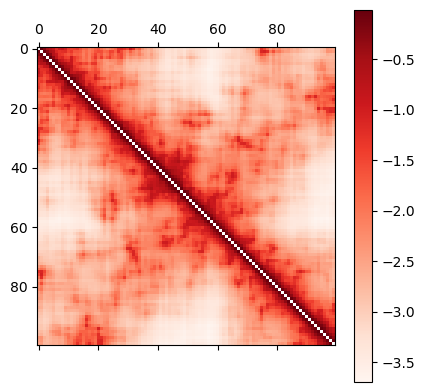

In [10]:
plt.matshow(np.log10(hic), cmap='Reds')
plt.colorbar()

In [9]:
from Analyzers import load_traj

In [10]:
data=load_traj(sim.reporters.get('position').filename)

data.shape

Loading trajectory ...
Trajectory shape: (10, 100, 3)


(10, 100, 3)

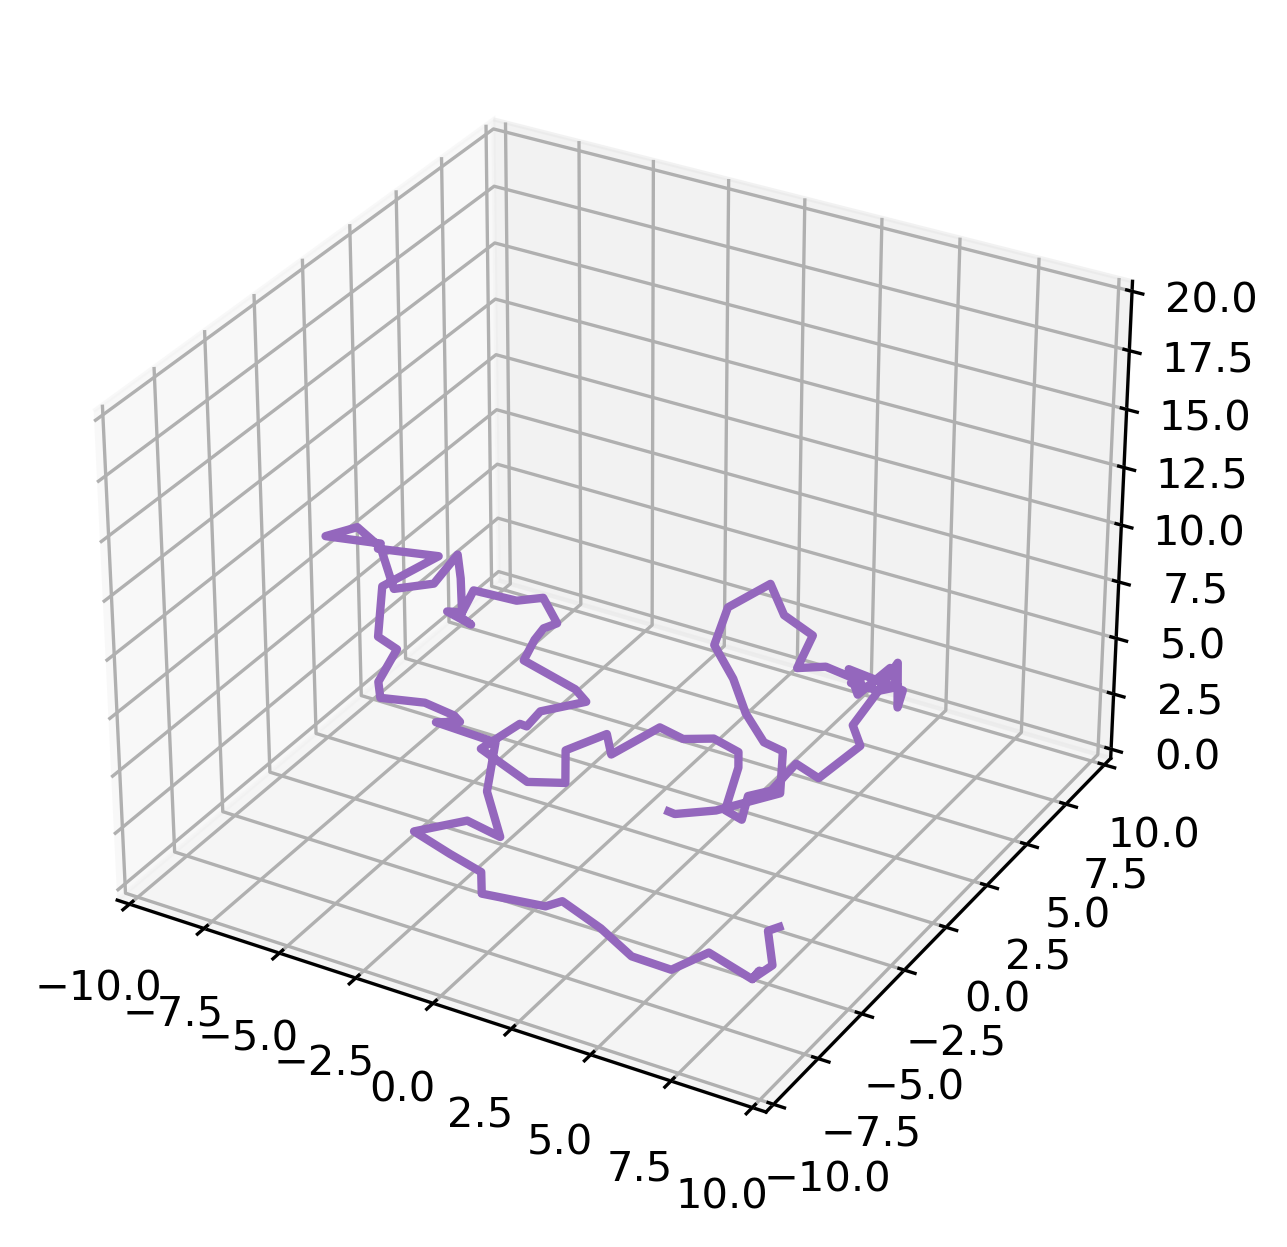

In [12]:
# Set up the 3D figure and axis
fig = plt.figure(figsize=(5,5), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Set axis limits (adjust as needed)
d=10.0
ax.set_xlim(-d,d)
ax.set_ylim(-d,d)
ax.set_zlim(0,2*d)

# Initial scatter plot
sc = ax.scatter([], [], [], s=50)

# Update function for each frame
def update(frame):
    # for coll in ax.collections:
        # coll.remove()
    ax.clear()
    positions = data[frame]
    
    ln = ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], lw=2, c='C4')
    
    ax.set_xlim(-d,d)
    ax.set_ylim(-d,d)
    ax.set_zlim(0,2*d)
    return ln,

# Create the animation
anim = FuncAnimation(fig, update, frames=data.shape[0], interval=150, blit=False)

# HTML(anim.to_html5_video())